**Caio Geraldes, 2021**

Este notebook testa a viabilidade dos algoritmos do módulo `lexicogenero`, de minha autoria, para selecionar, dividir e organizar dados de textos em prosa em grego antigo para a disciplina FLL5133-2021.
O código fonte dos scripts utilizados aqui, bem como dos testes de qualidade estão disponíveis em meu [GitHub](https://github.com/caiogeraldes/lexico-e-genero/).

# Carregamento e organização dos dados importados do Diorisis

Pretendo utilizar o corpus anotado [Diorisis](https://figshare.com/articles/dataset/The_Diorisis_Ancient_Greek_Corpus_JSON_/12251468) de Alessandro Vatri e Barbara McGillyvray, disponível em formato `.json` e com lemmatização confiável ([Vatri, 2020](https://brill.com/view/journals/jgl/20/2/article-p179_4.xml)).
 Para processar esse corpus, utilizei as funções criadas em [../src/lexicogenero/ferramentas/diorisis_reader.py](https://github.com/caiogeraldes/lexico-e-genero/blob/main/src/lexicogenero/ferramentas/diorisis_reader.py).
 A lista de *stop words* utilizada vem de [Rodda, 2020](https://github.com/MartinaAstridRodda/dphil-thesis), com algumas adições (código em [../src/lexicogenero/grc.py](https://github.com/caiogeraldes/lexico-e-genero/blob/main/src/lexicogenero/grc.py)).

In [1]:
import os
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
# evita a mensagem SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [2]:
from lexicogenero.ferramentas.diorisis_reader import carrega_textos, em_pandas, sent_pandas
from lexicogenero.main import DIORISIS_PATH
from lexicogenero.grc import STOPS_LIST

Neste teste, usaremos como corpus os textos de historiografia e prosa filosófica (diálogos e tratados) de autores do período clássico:

- Historiografia:
    - Heródoto
    - Xenofonte:
        - Ciropédia
        - Anábase
        - Helênica
    - Tucídides
- Prosa filosófica:
    - Platão
    - Xenofonte:
        - Agesilau
        - Hierão
        - Simpósio
        - Apologia
        - Memorabilia

In [3]:
DATA = "data.csv"
SENTS = "sents.csv"
REAPROVEITAR = True

if not REAPROVEITAR or (DATA not in os.listdir() or SENTS not in os.listdir()):
    ignorados = [
        "Xenophon (0032) - On the Art of Horsemanship (013).json",
        "Xenophon (0032) - Economics (003).json",
        "Xenophon (0032) - Ways and Means (011).json",
        "Xenophon (0032) - Constitution of the Lacedaemonians (010).json",
        "Xenophon (0032) - On the Cavalry Commander (012).json",
        "Xenophon (0032) - On Hunting (014).json",
        "Xenophon (0032) - Apology (005).json",
        "Plato (0059) - Alcibiades 2 (014).json", # Anotação problemática
    ]

    corpus = carrega_textos(autores=['Herodotus', 
                                     'Thucydides', 
                                     'Plato', 
                                     'Xenophon (0032)', # Exclui Xenofonte de Éfeso 
                                     ],
                            diorisis_path=DIORISIS_PATH,
                            ignore=ignorados,
                            verbose=False)
    df_tokens = em_pandas(corpus)
    df_sents = sent_pandas(corpus)
    del corpus
    df_tokens.to_csv(DATA, index=False)
    df_sents.to_csv(SENTS, index=False)
        
else:
    print('Carregando dataframe previamente salvo')
    df_tokens = pd.read_csv(DATA)
    df_sents = pd.read_csv(SENTS)

Carregando dataframe previamente salvo


**Formato do DF**: ainda não decidi se seria mais eficiente utilizar um data frame organizado por token ou por sentenças. A implementação de ambos é muito semelhante e pode ser vista em `../src/lexicogenero/ferramentas/diorisis_parser.py`

In [4]:
df_tokens.head()

,sent_id,location,form,lemma,POS,analyses,id,file,author,text
0,1,1.t.1,Ἡροδότου,Ἡρόδοτος,proper,masc gen sg,1,Herodotus (0016) - Histories (001).json,Herodotus,Histories
1,1,1.t.1,Ἁλικαρνησσέος,Ἁλικαρνησσεύς,proper,masc gen sg (epic ionic),2,Herodotus (0016) - Histories (001).json,Herodotus,Histories
2,1,1.t.1,ἱστορίης,ἱστορία,noun,fem gen sg (epic ionic),3,Herodotus (0016) - Histories (001).json,Herodotus,Histories
3,1,1.t.1,ἀπόδεξις,ἀπόδεξις,noun,fem nom sg,4,Herodotus (0016) - Histories (001).json,Herodotus,Histories
4,1,1.t.1,ἥδε,ὅδε,pronoun,fem nom sg,5,Herodotus (0016) - Histories (001).json,Herodotus,Histories


In [5]:
df_sents.head()

,sent_id,location,forms,lemmata,file,author,text
0,1,1.t.1,"Ἡροδότου Ἁλικαρνησσέος ἱστορίης ἀπόδεξις ἥδε ,...",Ἡρόδοτος Ἁλικαρνησσεύς ἱστορία ἀπόδεξις ὅδε ὡς...,Herodotus (0016) - Histories (001).json,Herodotus,Histories
1,2,1.1.1,Περσέων μέν νυν οἱ λόγιοι Φοίνικας αἰτίους φασ...,Πέρσευς μέν νῦν ὁ λόγιος Φοῖνιξ αἴτιος φημί γί...,Herodotus (0016) - Histories (001).json,Herodotus,Histories
2,3,1.1.2,τούτους γὰρ ἀπὸ τῆς Ἐρυθρῆς καλεομένης θαλάσση...,οὗτος γάρ ἀπό ὁ Ἐρυθραί καλέω θάλασσα ἀφικνέομ...,Herodotus (0016) - Histories (001).json,Herodotus,Histories
3,4,1.1.7,τὸ δὲ Ἄργος τοῦτον τὸν χρόνον προεῖχε ἅπασι τῶ...,ὁ δέ Ἄργος οὗτος ὁ χρόνος προέχω ἅπας ὁ ἐν ὁ ν...,Herodotus (0016) - Histories (001).json,Herodotus,Histories
4,5,1.1.9,ἀπικομένους δὲ τούς Φοίνικας ἐς δὴ τὸ Ἄργος το...,ἀφικνέομαι δέ ὁ Φοῖνιξ εἰς δή ὁ Ἄργος οὗτος δι...,Herodotus (0016) - Histories (001).json,Herodotus,Histories


## Anotando Gênero

In [6]:
hist = [
    "Herodotus (0016) - Histories (001).json",
    "Thucydides (0003) - History (001).json",
    "Xenophon (0032) - Hellenica (001).json",
    "Xenophon (0032) - Cyropaedia (007).json",
    "Xenophon (0032) - Anabasis (006).json",
]

In [7]:
# Deve haver uma maneira menos rocambolesca para resolver isso
df_tokens['genero'] = np.nan
df_tokens.loc[df_tokens.file.isin(hist), 'genero'] = "hist"
df_tokens.genero.fillna("filo", inplace=True)
df_sents['genero'] = np.nan
df_sents.loc[df_sents.file.isin(hist), 'genero'] = "hist"
df_sents.genero.fillna("filo", inplace=True)

Para meu modelo funcionar, será necessário ter uma quantidade relativamente equilibrada de dados entre autores de prosa historiográfica e prosa filosófica, a seleção parece razoável.
Qualquer tentativa de aumentar os dados de historiografia forçaria aumentar o escopo temporal (o próximo autor seria Políbio, já do período helenístico).
Nota-se que a diferença aumenta quando tratamos de sentenças e não de tokens, indicando que as sentenças em textos historiográficos devem ser um pouco mais longas na média.

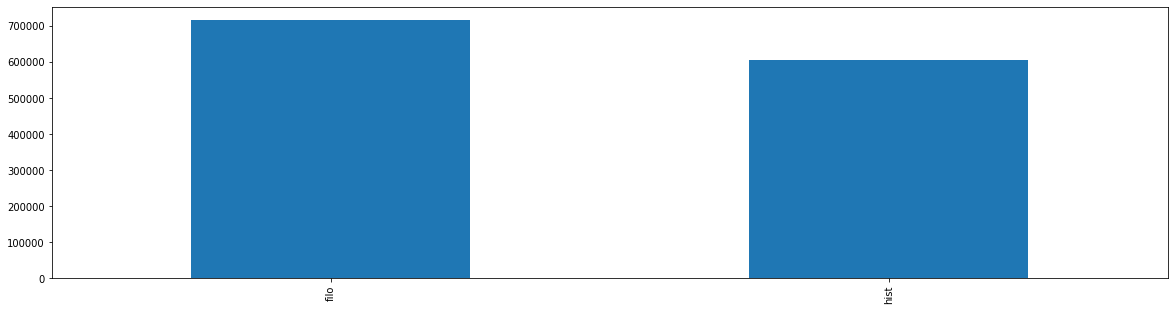

In [8]:
_ = df_tokens.genero.value_counts().plot(kind='bar')

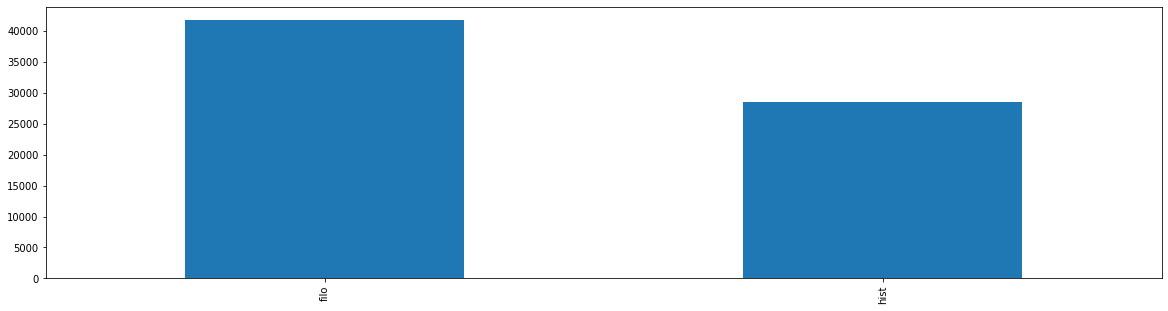

In [9]:
_ = df_sents.genero.value_counts().plot(kind='bar')

# Verbos por gênero (dataframe de tokens)

In [10]:
df_verbos = df_tokens.loc[(df_tokens.POS == "verb") & (-df_tokens.lemma.isin(STOPS_LIST)),]
df_verbos.head()

,sent_id,location,form,lemma,POS,analyses,id,file,author,text,genero
30,1,1.t.1,ἀποδεχθέντα,ἀποδέχομαι,verb,aor part pass neut nom/voc/acc pl;aor part pas...,28,Herodotus (0016) - Histories (001).json,Herodotus,Histories,hist
42,1,1.t.1,ἐπολέμησαν,πολεμέω,verb,aor ind act 3rd pl,38,Herodotus (0016) - Histories (001).json,Herodotus,Histories,hist
62,3,1.1.2,καλεομένης,καλέω,verb,fut part mid fem gen sg (attic epic ionic);pre...,6,Herodotus (0016) - Histories (001).json,Herodotus,Histories,hist
64,3,1.1.2,ἀπικομένους,ἀφικνέομαι,verb,aor part mid masc acc pl (ionic),8,Herodotus (0016) - Histories (001).json,Herodotus,Histories,hist
71,3,1.1.2,οἰκήσαντας,οἰκέω,verb,aor part act masc acc pl,14,Herodotus (0016) - Histories (001).json,Herodotus,Histories,hist


A filtragem não causa mudança na proporção entre documentos de historiografia e filosofia.

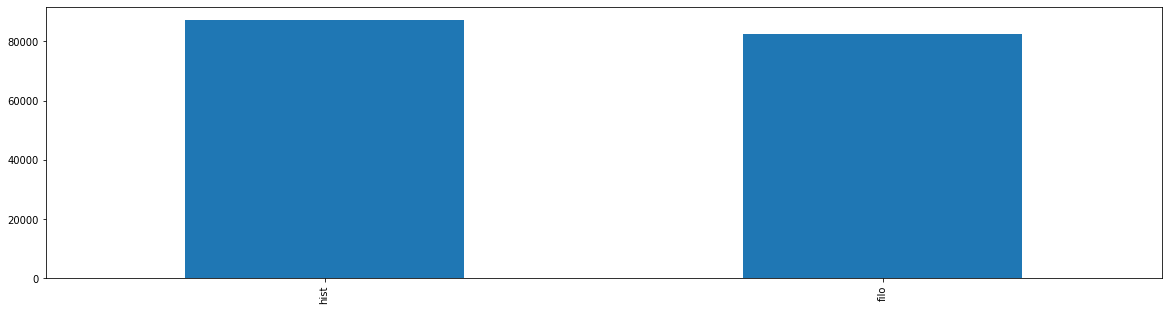

In [11]:
_ = df_verbos.genero.value_counts().plot(kind='bar')

In [12]:
filo_verbos = df_verbos[df_verbos.genero == "filo"].lemma
filo_verbos.value_counts()

οἴομαι          1728
οἶδα            1451
φαίνω           1198
βούλομαι        1163
δεῖ             1017
                ... 
ἀνακάμπτω          1
μαλακίζομαι        1
ἐναντιολογέω       1
παρωνυμέω          1
ἐφέζομαι           1
Name: lemma, Length: 3652, dtype: int64

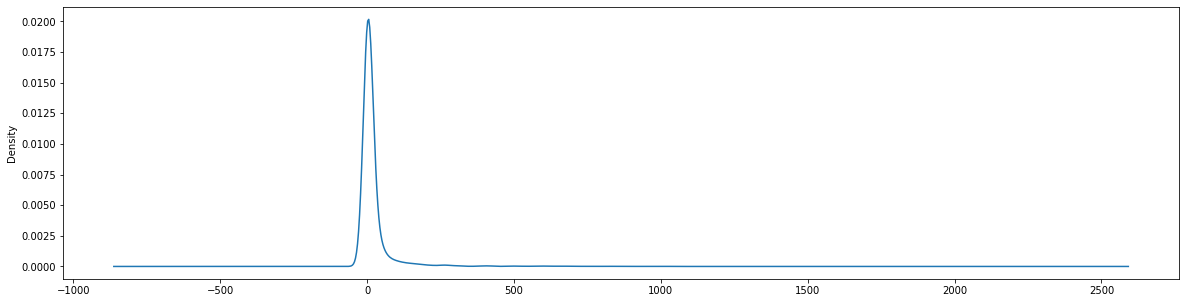

In [13]:
_ = filo_verbos.value_counts().plot(kind='density')

In [14]:
hist_verbos = df_verbos[df_verbos.genero == "hist"].lemma
hist_verbos.value_counts()

βούλομαι        1177
λαμβάνω          994
ἀφικνέομαι       915
ἔρχομαι          872
πάρειμι          822
                ... 
ἐπεικάζω           1
ἀποκηδεύω          1
πυκνόω             1
καθιππάζομαι       1
ἐξαυλίζομαι        1
Name: lemma, Length: 4331, dtype: int64

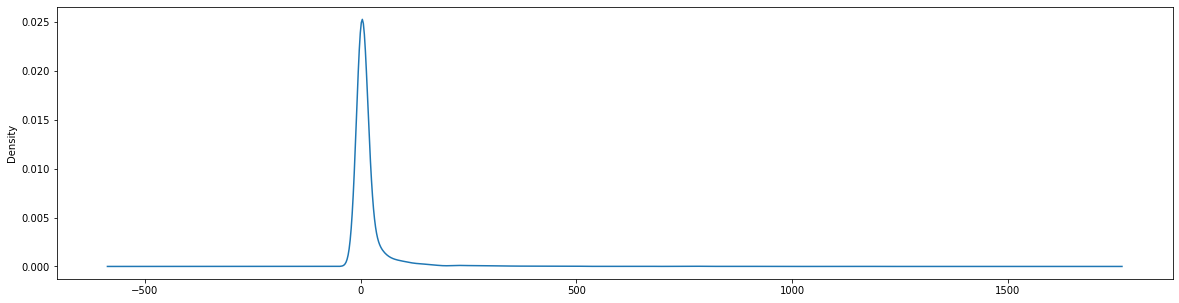

In [15]:
_ = hist_verbos.value_counts().plot(kind='density')

# Naive Bayes: Documento = sentença


Para comparar os resultados, salvarei os testes bem sucedidos em uma variável `resultados`

In [16]:
resultados = {}

In [17]:
def achatar(lista):
    return list(itertools.chain(*lista))

def naive_bayes(x, y, random_state=42):
    x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.20, random_state=random_state)

    filo = [x for x, y in zip(x_treino, y_treino) if y == 'filo']
    hist = [x for x, y in zip(x_treino, y_treino) if y == 'hist']
    
    vocab_filo = Counter(achatar(filo))
    vocab_hist = Counter(achatar(hist))
    
    n_filo = len(filo)
    n_hist = len(hist)
    n = n_filo + n_hist
    p_filo = np.log2(n_filo / n)
    p_hist = np.log2(n_hist / n)
    
    n_vocab_filo = len(vocab_filo)
    n_vocab_hist = len(vocab_hist)
    
    def pred_bayes(texto):
        texto_filo = [x for x in texto if x in vocab_filo.keys()]
        c_doc_filo = Counter(achatar(texto_filo))
        texto_hist = [x for x in texto if x in vocab_hist.keys()]
        c_doc_hist = Counter(achatar(texto_hist))

        pf_filo = sum([np.log2((c_doc_filo[token] + 1) / n_vocab_filo + len(texto_filo)) for token in texto_filo])
        pf_hist = sum([np.log2((c_doc_hist[token] + 1) / n_vocab_hist + len(texto_hist)) for token in texto_hist])


        prob_filo = p_filo + pf_filo
        prob_hist = p_hist + pf_hist


        return prob_filo, prob_hist
    
    teste_pred_labels = []
    for t in x_teste:
        prob_filo, prob_hist = pred_bayes(t)
        if prob_filo >= prob_hist:
            teste_pred_labels.append("filo")
        else:
            teste_pred_labels.append("hist")
    
    teste_orig_labels = [x for x in y_teste]

    return teste_pred_labels, teste_orig_labels


def performance(teste_pred_labels, teste_orig_labels):
    performance_labels = []

    for pred, label in zip(teste_pred_labels, teste_orig_labels):
        if label == "filo" and pred == "filo":
            performance_labels.append("VP")
        elif label == "filo" and pred == "hist":
            performance_labels.append("FP")
        elif label == "hist" and pred == "hist":
            performance_labels.append("VN")
        else:
            performance_labels.append("FN")

    return Counter(performance_labels)
    
    
def metricas(perf_counter, verbose=True):
    
    if (perf_counter['VP'] + perf_counter['FP'] == 0) or (perf_counter['VP'] + perf_counter['FN'] == 0):
        return {'precisão': np.nan, 'cobertura': np.nan, 'acurácia': np.nan, 'medida_f1': np.nan}
    
    else:
        precisao = perf_counter['VP'] / (perf_counter['VP'] + perf_counter['FP'])
        cobertura = perf_counter['VP'] / (perf_counter['VP'] + perf_counter['FN'])
        acuracia = (perf_counter['VP'] + perf_counter['VN']) / sum(perf_counter.values())
        medida_f = 2 * (precisao * cobertura) / (precisao + cobertura)
        
        if verbose:
            print(f'Precisão:  {precisao}')
            print(f'Cobertura: {cobertura}')
            print(f'Acurácia:  {acuracia}')
            print(f'Medida F:  {medida_f}')
    
        return {'precisão': precisao, 'cobertura': cobertura, 'acurácia': acuracia, 'medida_f1': medida_f}



## Apenas de tokens de verbos

O resultado é terrível, provavelmente porque a implementação do modelo não é a melhor, afinal o `DOCUMENTO` e suas componentes são a mesma entidade.

In [18]:
j = df_verbos.groupby(['author', 'text', 'file', 'sent_id', 'genero']).agg({
    'lemma': lambda x: " ".join(x),
})

df_verbos_sent = j.reset_index().loc[:,:]
df_verbos_sent['lst_lemmata'] = df_verbos_sent.lemma.str.split()

In [19]:
x, y = df_verbos_sent.lst_lemmata, df_verbos_sent.genero

Como o modelo apenas previu a `label` 'hist', o resultado saiu inutilizável para testes de performance.

In [20]:
pred,true = naive_bayes(x, y, random_state=42)

In [21]:
Counter(pred)

Counter({'filo': 9849, 'hist': 936})

In [22]:
Counter(true)

Counter({'hist': 5246, 'filo': 5539})

In [23]:
perf_counter = performance(pred,true)
perf_counter

Counter({'FN': 4377, 'VP': 5472, 'VN': 869, 'FP': 67})

In [24]:
resultados['doc-sent-verbos'] = metricas(perf_counter)

Precisão:  0.9879039537822711
Cobertura: 0.5555893999390801
Acurácia:  0.5879462216040797
Medida F:  0.7112035352222511


## Todos os tokens

O modelo assim performa melhor, mas é pouco específico para os meus interesses: que o vocabulário da prosa filosófica e historiográfica são distintos diz pouco sobre sua seleção de verbos.

In [25]:
df_sents['lst_lemmata'] = df_sents.lemmata.str.split()
df_sents.dropna(inplace=True)

In [26]:
x, y = df_sents.lst_lemmata, df_sents.genero

pred, true = naive_bayes(x, y, random_state=42)
perf_counter = performance(pred, true)
resultados["doc-sent-tudo"] = metricas(perf_counter)

Precisão:  0.9813494891898313
Cobertura: 0.7373259550160657
Acurácia:  0.779782624138666
Medida F:  0.8420140658444601


# Conclusões parciais

- O banco de dados anotado Diorisis oferece as anotações necessárias e é relativamente fácil de processar.
- O corpus proposto oferece um número relativamente equilibrado de dados para as categorias a serem classificadas e o algoritmo de processamento permite que ele seja expandido conforme necessário.
- Será importante revisar a suavização utilizada (no caso Laplace) para poder obter um modelo funcional se for utilizado um modelo como o Naive Bayes apenas com os verbos, embora a princípio já seja possível afirmar que esse modelo não funcionará bem assim.
- Se for possível codificar a informação de `df_sents.lst_lemmata` selecionar os verbos principais (utilizando o dependency parser do `stanza-perseus`), os resultados poderão ser mais consistentes com aqueles que são de meu interesse.

# Novos testes

## Documento = Parágrafo

### Metodologia de divisão em parágrafos

Testando os exemplos por meio de agrupamento em parágrafos.
Para produzir os parágrafos, assumirei que as notações tradicionais de divisão do texto, guardadas na variável `location` correspondem aproximadamente à divisão natural de parágrafos.
Assim:

In [27]:
df_tokens[['div_sup', 'par']] = df_tokens.location.str.split('.', n=1, expand=True)

df_tokens.dropna(inplace=True)

j = df_tokens.groupby(['author', 'text', 'file','div_sup', 'par', 'genero']).agg({
    'lemma': lambda x: " ".join(x),
})

df_tokens_par = j.reset_index().loc[:,:]

In [28]:
df_tokens_par.sample(n=5, random_state=15)

,author,text,file,div_sup,par,genero,lemma
17607,Plato,Laws,Plato (0059) - Laws (034).json,732,b.5,filo,ὅς δέ μικρός μέν οὗτος καί λέγω πολλάκις εἰμί ...
49103,Xenophon,Cyropaedia,Xenophon (0032) - Cyropaedia (007).json,7,1.44.1,hist,ἀκούω οὗτος ὁ Αἰγύπτιος ὁ μέν ἐπί Κροῖσος συστ...
32008,Plato,Sophist,Plato (0059) - Sophist (007).json,241,e.1,filo,οὗτος γάρ μήτε ἐλέγχω μήτε ὁμολογέω σχολή ποτέ...
1768,Herodotus,Histories,Herodotus (0016) - Histories (001).json,2,162.22,hist,ὡς δέ ἀφικνέομαι αὐτός πρός ὁ Ἀπρίης οὐ ἄγω ὁ ...
39371,Thucydides,History,Thucydides (0003) - History (001).json,4,16.1.10,hist,οὗτος δέ ὁράω ὁ Ἀθήναια εἰσπέμπω καί πλοῖον μη...


No entanto, como a divisão tradicional dos textos platônicos segue o padrão das páginas Stephanus, é de se imaginar que o tamanho dos parágrafos será artificialmente normalizado, o que por um lado lhe dará uma distribuição anormal em relação aos demais e por outro causará um número grande de outliers, dado que a maioria estará concentrada em uma faixa de frequência.
Além disso, a variação de tamanho dos parágrafos é muito grande no geral, sendo importante filtrar os dados para que essa variação não seja carregada pelo modelo.

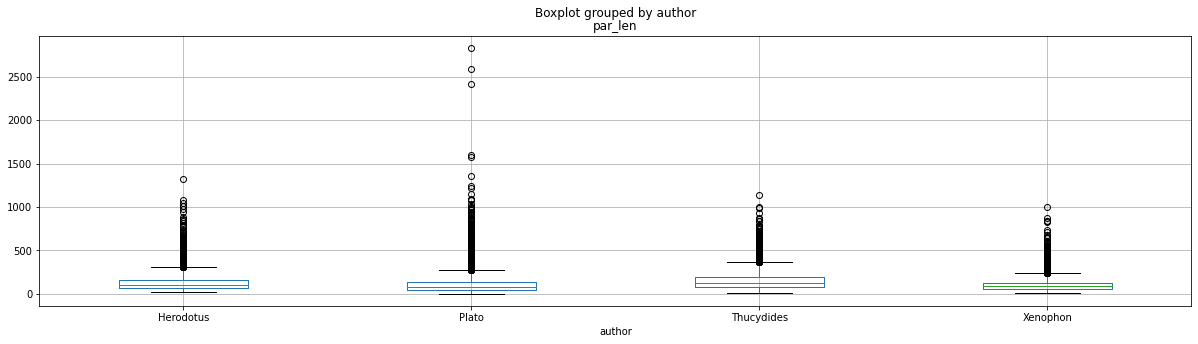

In [29]:
df_tokens_par['par_len'] = df_tokens_par.lemma.apply(len)
_ = df_tokens_par.boxplot(column='par_len', by='author')

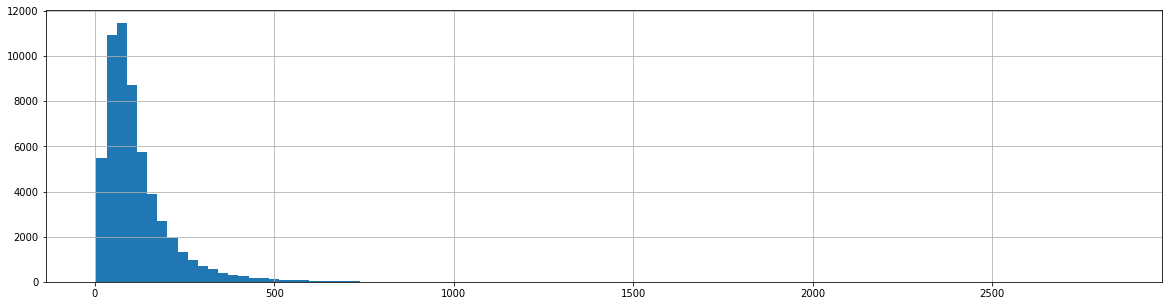

In [30]:
_ = df_tokens_par.par_len.hist(bins=100)

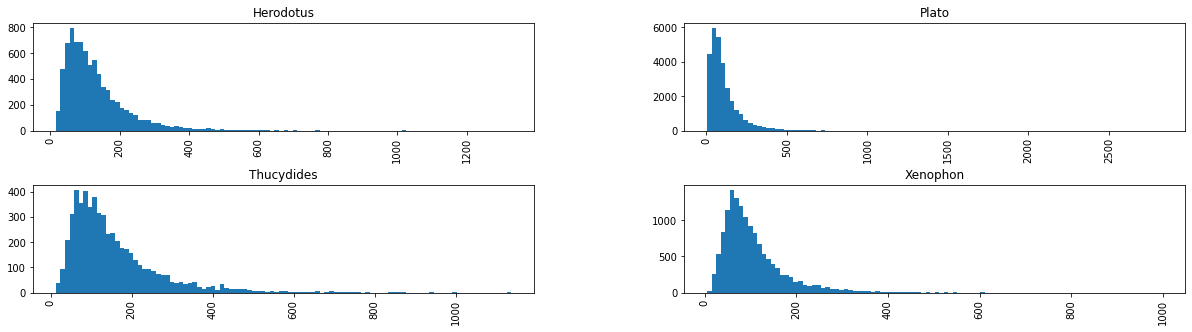

In [31]:
_ = df_tokens_par.par_len.hist(bins=100, by=df_tokens_par.author)

Para ajustar um pouco a divisão, excluo os quantis abaixo de 5% e acima de 95%, chegando a uma distribuição mais aceitável.

In [32]:
minimo, maximo = df_tokens_par.par_len.quantile([.05, .95]).values
tamanho_representativo = (df_tokens_par.par_len > minimo) & (df_tokens_par.par_len < maximo)

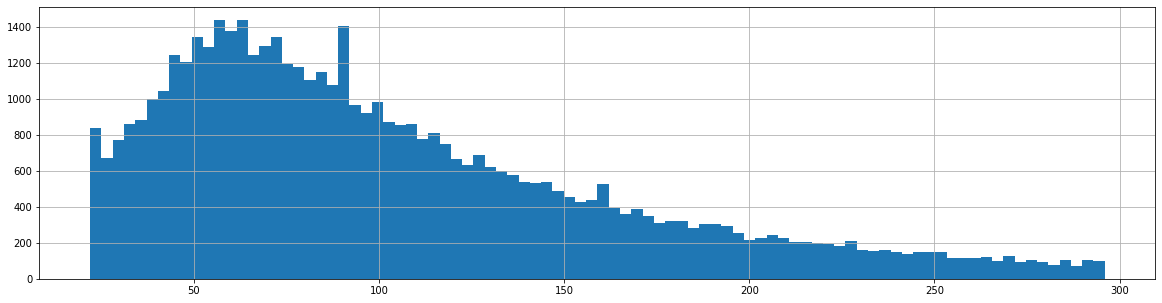

In [33]:
_ = df_tokens_par.loc[tamanho_representativo].par_len.hist(bins=90)

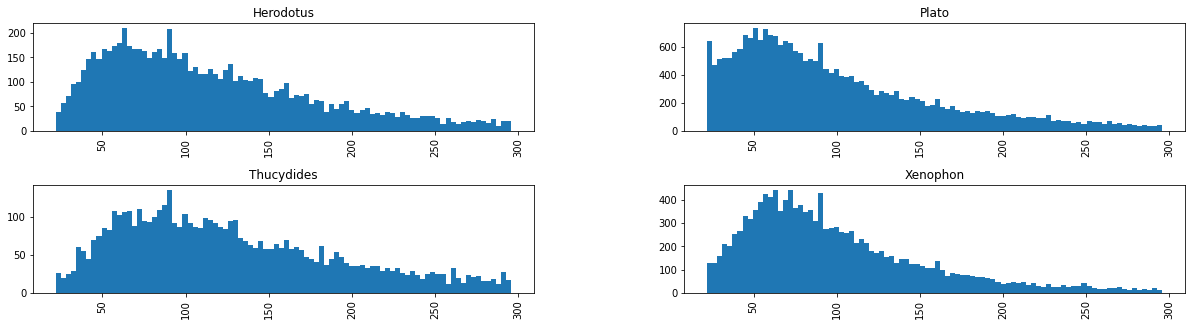

In [34]:
_ = df_tokens_par.loc[tamanho_representativo].par_len.hist(bins=90, by=df_tokens_par.author)

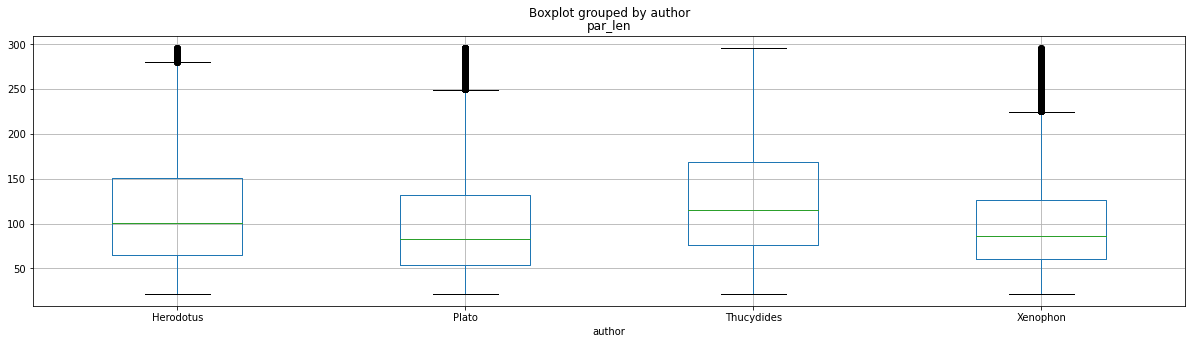

In [35]:
_ = df_tokens_par.loc[tamanho_representativo].boxplot(column='par_len', by='author')

O resto é como visto anteriormente.

### Utilizando todos os tokens

In [36]:
df_tokens_par['lst_lemmata'] = df_tokens_par.lemma.str.split()

In [37]:
x, y = df_tokens_par.lst_lemmata, df_tokens_par.genero

pred, true = naive_bayes(x, y)
perf_counter = performance(pred, true)
resultados["doc-par-tudo"] = metricas(perf_counter)

Precisão:  0.9732654360280076
Cobertura: 0.7165787932044523
Acurácia:  0.7702894690108328
Medida F:  0.8254268169242188


### Utilizando apenas os verbos

O mesmo pode ser feito apenas com os verbos, que com a divisão em parágrafos, performa muito mais adequadamente:

In [38]:
df_verbos[['div_sup', 'par']] = df_verbos.location.str.split('.', n=1, expand=True)

j = df_verbos.groupby(['author', 'text', 'file','div_sup', 'par', 'genero']).agg({
    'lemma': lambda x: " ".join(x),
})

df_verbos_par = j.reset_index().loc[:,:]

df_verbos_par['lst_lemmata'] = df_verbos_par.lemma.str.split()
df_verbos_par

,author,text,file,div_sup,par,genero,lemma,lst_lemmata
0,Herodotus,Histories,Herodotus (0016) - Histories (001).json,1,1.14,hist,ἵστημι ὠνέομαι διακελεύομαι ὁρμάω,"[ἵστημι, ὠνέομαι, διακελεύομαι, ὁρμάω]"
1,Herodotus,Histories,Herodotus (0016) - Histories (001).json,1,1.17,hist,πλείων ἀποφεύγω ἁρπάζω,"[πλείων, ἀποφεύγω, ἁρπάζω]"
2,Herodotus,Histories,Herodotus (0016) - Histories (001).json,1,1.19,hist,εἰσβάλλω οἴχομαι ἀποπλέω,"[εἰσβάλλω, οἴχομαι, ἀποπλέω]"
3,Herodotus,Histories,Herodotus (0016) - Histories (001).json,1,1.2,hist,καλέω ἀφικνέομαι οἰκέω οἰκέω ἐπιτίθημι ἀπαγινέ...,"[καλέω, ἀφικνέομαι, οἰκέω, οἰκέω, ἐπιτίθημι, ἀ..."
4,Herodotus,Histories,Herodotus (0016) - Histories (001).json,1,1.7,hist,προέχω καλέω χωράζω,"[προέχω, καλέω, χωράζω]"
...,...,...,...,...,...,...,...,...
47902,Xenophon,Symposium,Xenophon (0032) - Symposium (004).json,9,5.3,filo,ὁράω εἰσλάω φιλόω ἀναπτερόω θεάομαι,"[ὁράω, εἰσλάω, φιλόω, ἀναπτερόω, θεάομαι]"
47903,Xenophon,Symposium,Xenophon (0032) - Symposium (004).json,9,6.1,filo,ἀκούω ἐπερωτάω φιλέω ἐπόμνυμι πάρειμι συνόμνυμ...,"[ἀκούω, ἐπερωτάω, φιλέω, ἐπόμνυμι, πάρειμι, συ..."
47904,Xenophon,Symposium,Xenophon (0032) - Symposium (004).json,9,6.5,filo,ἔοικα διδάσκω ἐφέζομαι πράσσω ἐπιθυμέω,"[ἔοικα, διδάσκω, ἐφέζομαι, πράσσω, ἐπιθυμέω]"
47905,Xenophon,Symposium,Xenophon (0032) - Symposium (004).json,9,7.1,filo,εἶδον περιβάλλω ἄπειμι γαμέω ἐπόμνυμι γαμέω ἀν...,"[εἶδον, περιβάλλω, ἄπειμι, γαμέω, ἐπόμνυμι, γα..."


In [39]:
x, y = df_verbos_par.lst_lemmata, df_verbos_par.genero

In [40]:
pred, true = naive_bayes(x, y, random_state=42)
perf_counter = performance(pred, true)
resultados["doc-par-verbo"] = metricas(perf_counter)

Precisão:  0.981159123489658
Cobertura: 0.5583265353688381
Acurácia:  0.5948653725735754
Medida F:  0.7116755793226381


# Conclusões após uma rodada

Comparando os resultados:

In [41]:
df_resultados = pd.DataFrame(resultados).transpose()
df_resultados.reset_index(inplace=True)
df_resultados = df_resultados.rename(columns = {'index':'modelo'})
df_resultados

,modelo,precisão,cobertura,acurácia,medida_f1
0,doc-sent-verbos,0.987904,0.555589,0.587946,0.711204
1,doc-sent-tudo,0.981349,0.737326,0.779783,0.842014
2,doc-par-tudo,0.973265,0.716579,0.770289,0.825427
3,doc-par-verbo,0.981159,0.558327,0.594865,0.711676


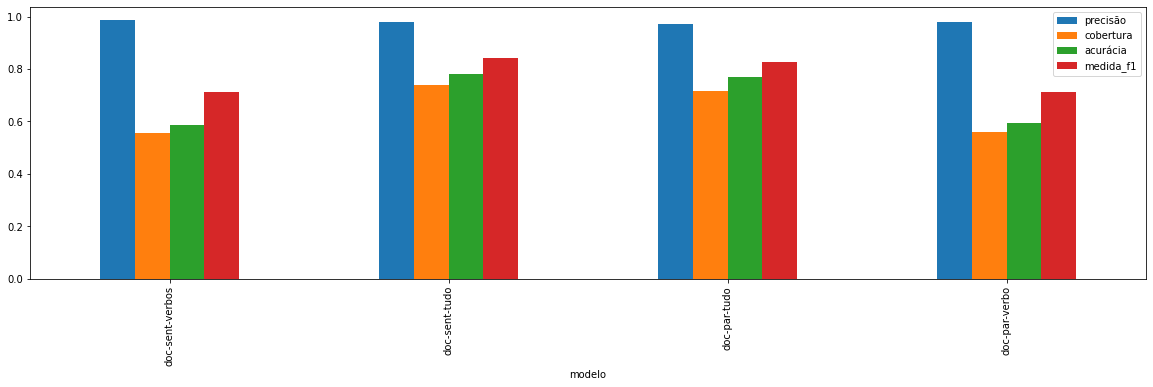

In [42]:
_ = df_resultados.dropna().plot(kind='bar', x='modelo')

1. Curiosamente, não há grandes diferenças entre os resultados dos modelos com sentenças consideradas como documentos e dos modelos com parágrafos considerados como documentos.
2. A precisão se mantém relativamente estável em todos os modelos, embora acurácia, cobertura e f1 caiam drasticamente nos modelos apenas com verbos.

# Conclusões após 100 rodadas

Randomizando os resultados (extramemente lento, posto que perde-se muito tempo recriando variáveis por conta da minha implementação questionável da função `naive_bayes`).
Os modelos estão abreviados como:
- doc-sent-verbos = dsv
- doc-sent-tudo = dst
- doc-par-verbos = dpv
- doc-par-tudo = dpt

In [45]:
resultados_randomizados = []
x_dsv, y_dsv = df_verbos_sent.lst_lemmata, df_verbos_sent.genero
x_dst, y_dst = df_sents.lst_lemmata, df_sents.genero
x_dpt, y_dpt = df_tokens_par.lst_lemmata, df_tokens_par.genero
x_dpv, y_dpv = df_verbos_par.lst_lemmata, df_verbos_par.genero

for j in range(100):
    i = np.random.randint(1,100)
    
    pred, true = naive_bayes(x_dsv, y_dsv, random_state=i)
    perf_counter = performance(pred, true)
    resultados_randomizados.append({**{'modelo': 'doc-sent-verbos'}, **metricas(perf_counter, False)})
    
    pred, true = naive_bayes(x_dst, y_dst, random_state=i)
    perf_counter = performance(pred, true)
    resultados_randomizados.append({**{'modelo': 'doc-sent-tudo'}, **metricas(perf_counter, False)})

    pred, true = naive_bayes(x_dpt, y_dpt, random_state=i)
    perf_counter = performance(pred, true)
    resultados_randomizados.append({**{'modelo': 'doc-par-tudo'}, **metricas(perf_counter, False)})

    pred, true = naive_bayes(x_dpv, y_dpv, random_state=i)
    perf_counter = performance(pred, true)
    resultados_randomizados.append({**{'modelo': 'doc-par-verbos'}, **metricas(perf_counter, False)})


In [46]:
df_rr = pd.DataFrame(resultados_randomizados)

In [47]:
dpv = df_rr.loc[df_rr['modelo'] == "doc-par-verbos"]
dpt = df_rr.loc[df_rr['modelo'] == "doc-par-tudo"]
dst = df_rr.loc[df_rr['modelo'] == "doc-sent-tudo"]
dsv = df_rr.loc[df_rr['modelo'] == "doc-sent-verbos"]

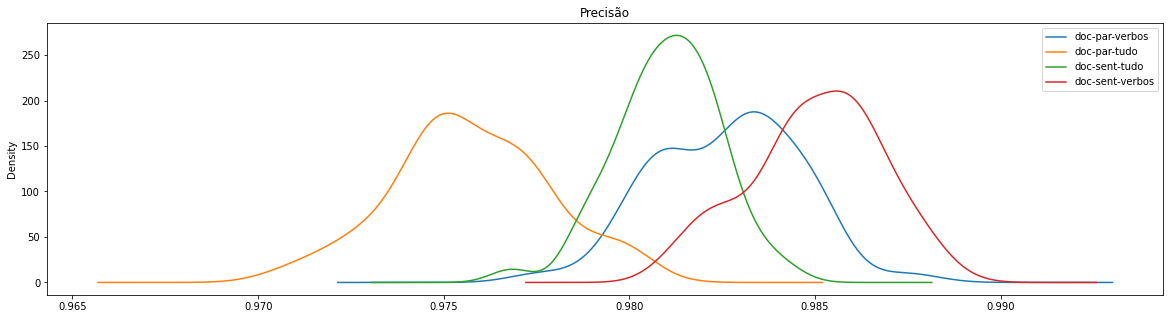

In [64]:
dpv['precisão'].plot(kind='kde')
dpt['precisão'].plot(kind='kde')
dst['precisão'].plot(kind='kde')
dsv['precisão'].plot(kind='kde')
plt.title("Precisão")
plt.legend(labels = ['doc-par-verbos', 'doc-par-tudo', 'doc-sent-tudo', 'doc-sent-verbos'])
plt.show()

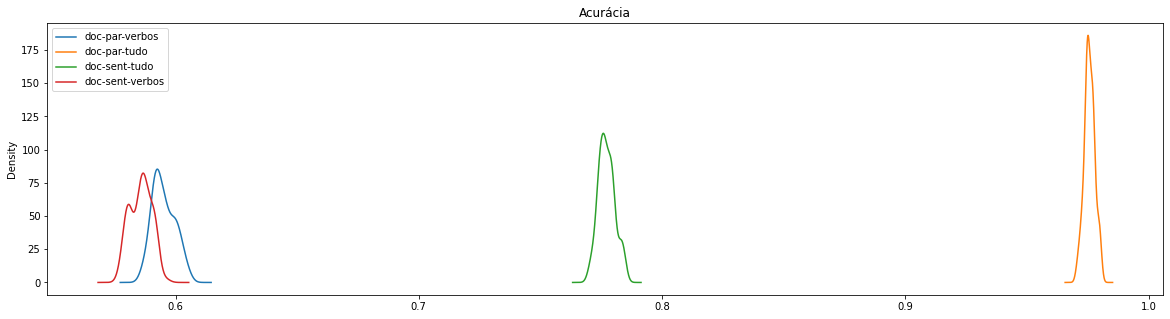

In [63]:
dpv['acurácia'].plot(kind='kde')
dpt['precisão'].plot(kind='kde')
dst['acurácia'].plot(kind='kde')
dsv['acurácia'].plot(kind='kde')
plt.title("Acurácia")
plt.legend(labels = ['doc-par-verbos', 'doc-par-tudo', 'doc-sent-tudo', 'doc-sent-verbos'])
plt.show()

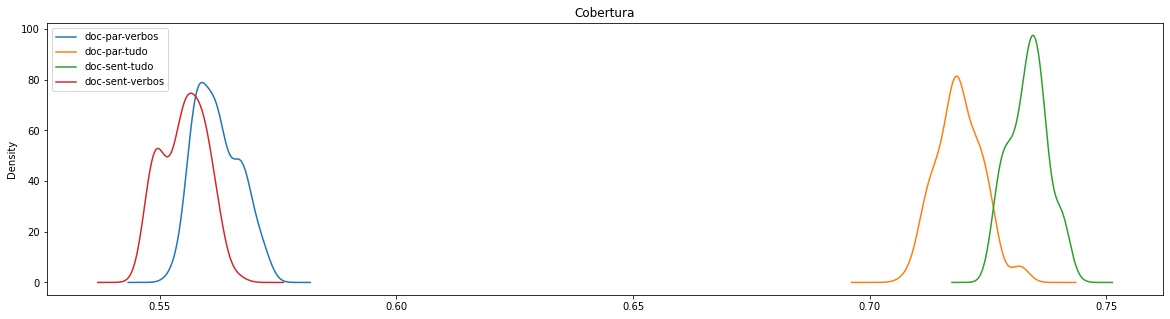

In [62]:
dpv['cobertura'].plot(kind='kde')
dpt['cobertura'].plot(kind='kde')
dst['cobertura'].plot(kind='kde')
dsv['cobertura'].plot(kind='kde')
plt.title("Cobertura")
plt.legend(labels = ['doc-par-verbos', 'doc-par-tudo', 'doc-sent-tudo', 'doc-sent-verbos'])
plt.show()

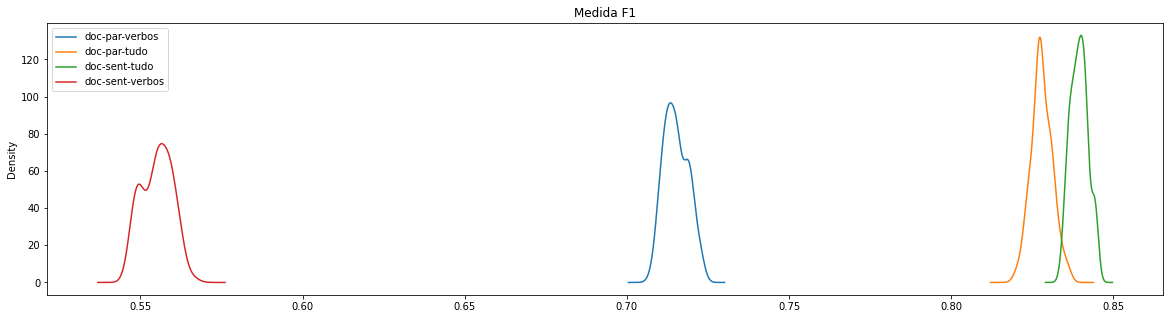

In [61]:
dpv['medida_f1'].plot(kind='kde')
dpt['medida_f1'].plot(kind='kde')
dst['medida_f1'].plot(kind='kde')
dsv['cobertura'].plot(kind='kde')
plt.title("Medida F1")
plt.legend(labels = ['doc-par-verbos', 'doc-par-tudo', 'doc-sent-tudo', 'doc-sent-verbos'])
plt.show()